# Data Mining Course Spark Exercise
## Sharif University of Technology

In this notebook we are going to analyze farsi news.
Outline of the exercise:
* Dataset preparation
* Preprocessing
* Exploration
* Word Collections

You should replace the `TODO` parts with your implementation. Remeber that each `TODO` may take multiple lines and you shouldn't limit your self to one-line codes.

## Prerequisites
You should be faimilar with [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). In this notebook you should use the following formula for tf-idf:
$$f_{t,d}/len(d) \times log(1 + \frac{N}{n_t})$$

## Warning: RDD api only
You **can not** use Dataframe, Dataset, mllib, ml, ... apis of spark in this exercise. You should only use the [RDD api](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD).

# Please enter your name below:
# Name: Mohammad Javad Noroozi
# Student Number: 99102434

# Section 1: Dataset prepartition
This section you need to download [dataset](https://drive.google.com/file/d/1bRxHQDzPr6wDimbM7b89H47kH8O3YV8Y/view?usp=sharing) in a directory you work. After that run the below cell to untar the datase.

**Note 1: Don't change the below command.**

**Note 2: If you use Windows OS, unzip the dataset manually.**

## Install Pypark & Initialization
Uncomment this section if you use google colab or local pc

In [ ]:
# ! pip install pyspark

In [1]:
import findspark
findspark.find()
findspark.init()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("HW1") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

23/12/21 16:57:00 WARN Utils: Your hostname, javad-IdeaPad-Gaming-3-15IAH7 resolves to a loopback address: 127.0.1.1; using 192.168.43.226 instead (on interface wlp0s20f3)
23/12/21 16:57:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/21 16:57:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Reading the data

In [2]:
news_rdd = sc.textFile("news_data.jsonl")
news_rdd.takeSample(False, 1, 12)

['{"body": "نشست بزرگداشت روز جهانی حافظ شیرازی 20 مهرماه در دانشگاه پکن برگزار می شود.\\n\\n- ایرنا نوشت: با همکاری مشترک گروه زبان و ادبیات فارسی دانشگاه پکن و رایزنی فرهنگی جمهوری اسلامی ایران در چین، نشست بزرگداشت روز جهانی حافظ شیرازی روز پنجشنبه 20 مهرماه ساعت 10:30 تا 12 در دانشگاه پکن برگزار می شود.\\n\\nدر این نشست، محسن بختیار، سفیر و نعمت الله ایران زاده، رایزن فرهنگی جمهوری اسلامی ایران در چین، پروفسور چن مینْگ، رییس محترم دانشکده زبان های خارجی دانشگاه پکن، بهادر باقری، استاد مدعو زبان و ادبیات فارسی دانشکده زبان های خارجی دانشگاه پکن، سخنرانی می کنند.\\n\\nخانم وانگ یی دان، استاد رشته زبان و ادبیات فارسی دانشگاه پکن، شی گوانگ، استاد رشته زبان و ادبیات فارسی و مدیر مرکز پژوهش های فرهنگ ایران در دانشگاه پکن و لیو یینگ جون، استاد و مدیر گروه زبان و ادبیات فارسی دانشگاه پکن از دیگر سخنرانان این نشست هستند.", "image_title_url": "https://ettelaat.com/files/fa/news/1402/7/20/82679_282.jpg", "language": "fa", "source": "موتور جستجوی قطره", "title": "ادای احترام چینی ها به حافظ +ع

# Section 2: Preprocessing
This section we try to normalize news and remove useless characters (for example /n and /u200c and ...). Also find and remove stop words.

In [3]:
!pip install wordcloud-fa
!pip install wordcloud
!pip3 install Pillow==9.5.0
!pip install opencv-python
## !pip install persian-wordcloud


In [3]:
# import neccesary packages here
import json
import re
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.ml.feature import StopWordsRemover
from wordcloud import WordCloud
from wordcloud_fa import WordCloudFa

In [4]:
news_rdd = news_rdd.sample(False, 0.5, seed=42)


In [5]:
"""
TODO
Step 1: Remove useless charachters.
Step 2: Find and Remove stop words.
"""
# Step 1: Remove useless characters
# news_rdd = ... #TODO: parse the json string
# clean_news_rdd = ... #TODO: remove useless charachters
clean_news_rdd = news_rdd.map(lambda x:  re.sub('[^\w\s]+', '', json.loads(x)["body"]))
# clean_news_rdd = news_rdd.map(lambda x: (json.loads(x)["uid"], re.sub('[^A-Z a-z 0-9 \s ا-ی ۰-۹ ]+', '', json.loads(x)["body"])))

# Step 2: find and remove stopwords.
# stop_words = ["این", "آن", "را", "با", "برای", "و", "در", "به", "از", "که", "اینکه", "یا", "او", \
#                            "ما", "آنها", "وی", "خود", "است", "هست", "دارد", "داشت", "کرد", "شما", "آنها", \
#                             "شد", "شدند", "تا", "بر", "هم", "بود", "می", "نیز", "شود", "ایشان",\
#                            "های", "اما", "هر", "شده", "همه", "هرچه", "خواهد", "داد", "دیگر", \
#                             "کنید", "کنیم", "کنند", "کند", "کرد", "کردم", "کردن", "کردند", "باید"\
#                            , "میشود", "گفت", "وی", "کرده", "ادامه", "میخوانید", "میکنم", "درباره", "یک", "دو"\
#                            , "سه", "چهار", "یکی", "مورد", "میکنید", "کنید", "روی", "اینطور", "باشم", "باشد", \
#                            "باشید", "باشیم", "آنچنان", "هم", "نگه", "داریم", "شماست", "اوست", "مانند", \
#                            "میتواند", "میتوانند", "میتوانید", "میکند", "نمیشود", "میشد", "بسیار", "بیشتر", \
#                            "چه", "بوده", "دارند", "مگر", "فقط", "کسی", "کس", "همانطور", "همچنان", \
#                            "همچنین", "همچین", "اصلا", "هستند", "هستید", "هست", "هستیم", "اساس", "بودن", "باشند", \
#                            "بودن", "من", "تو", "بدون", "طی", "ها", "نه", "کننده", "چند", "حتی", "گرفت", "بودند",\
#                            "ضمن", "خوب", "دهند", "رسیده", "میشوند", "رسید", "چون", "چرا", "کامل", "برخی", "غیر", \
#                            "شوند", "آیا", "میدهد", "بی", "دادند", "پی", "پس", "افزود", "وجود", "پیش", "بین", "وجود", "گرفته", "داشته"]

# source: https://aftab.cc/article/1232-لیستی-از-کلمات-بازدارنده-در-زبان-فارسی---Stop-Words-in-Persian
stop_words = set(" گردد نحوه  دوباره‌ای خواهیمكرد توانند می‌توانند می فرماید می‌فرماید وجود دارد باشیم بنابراین برخوردار نمیمونید ساخته‌ام میخواستن خواستن خواستند خواستیم نمیگیرند همچنانكه نمیمونید میخواهند تواند باشند می‌تواند می‌باشند استفاده  جلوگیری نمیكنند رابسیار مینوشند نمیاورم رفته رفته‌ام اینطوری شده‌اند می شوند می کنند می توان می باشد می‌شوند می‌کنند می‌توان می‌باشد کند هدف کلی چنین همچنین  درباره بسیاری اساس براساس خواهند توانند اولین دومین آخرین نهایی نخستین تاكنون برداری بهترین بیشتری داشتند نخواهد دیگران همچنان ندارند روز روزهای یكدیگر همواره گذاشته  نداشته خواهیم نخواهیم درون بیرونِ پایین پاعینِ نزدیكِ دنبالِ دنبال برابر برابرِ مانند مانندِ هنگامِ هنگام عنوانِ عنوان البتّه البته وقتیكه هنگامی میكنند همانند پیششون میباشد میگردد درباره میدهیم بینمان مهمتر مهمتره بیاریم نمیبرد نمیروند نمیروم شناسید بریزید میكنیم علارغم نمیكنن اینجور میگیره میكنند میشوند می شود می کند می‌شود می‌کند می آید می‌آید این ها این جا اینجا اینها این‌ها نخواهد نخواهند خواهند خواهد هستند داشته کردیم نکردیم نکرد نکردند كردند دارند بیشتر بسیار گرفته تواند اینكه مختلف گزاری گذاری بودند دیروز امروز باشند ندارد دیگری اكنون البته مقابل امسال  قرار پارسال مانند جریان ساخته نزدیك دانستند ندانست دانست تمامی ایشان ندادند دادند هنگام نباید نداریم دارند ندارند داریم چگونه خواست هستند هست هستید هستیم سراسر گروهی آورده نماید باشی باشم باشند باشیم گویند شناسی نداشتن داشتن همچون نكرده دانند بالای خارجِ كنارِ کنار حدود حدودِ علت علّتِ كجاست چندین لطفا لطفاً مدتی مدت مدّتی میكنن هممون زدند نزدند زد نزد زدیم نزدیم دارای نشود نشوند بشود بشوند یگردی عمدا عمدتا آورده برای وبرای بتوان نتوان نتوانیم نتوانند ندیدی خوبی بخوبی بدهید نکنیم نكنند بوجود میكنم میکنیم میکنید میكند میكنه دانست دانستن دانستند دونید گرفتن گرفتند گرفتید بگیرد بگیرند بگیرم زدن زدم زدی زدیم زدند بزنیم بزن بزنند بزنید توانستید توانستن توانست تونست نداشتیم نداشتم نداشتند نداشتید نداشتی نداشت ندارم نداریم ندارید نداری نداره کردیم کردند کردن کردم كردید بود بودن بودند نبود نبودید نبودن نبودند بودید واقعا هستند هستیم هست هستید اینجا بهشون ایشان میكنن میکنند میکنیم میکنید میکنم میکند میکرد کرد کردم میکردم میرم میروم اونجا میدهم میداد میدهد كردیم می شد می‌شد میشد  میان حالی درحال درحالی سر سایر خصوص میتواند کل جز میشود کرده  کامل برخی غیر شوند میدهد بی دادند پی پس افزود وجود پیش بین وجود گرفته داشته ضمن خوب دهند رسیده میشوند رسید چون چرا برخی بودن من تو بدون طی ها نه کننده چند حتی گرفت بودند باشند هستند هستید هست هستیم چه بوده دارند مگر فقط کسی همانطور همچنان میکند نمیشود میشد اوست نگه هم آنچنان باشیم باشید یکی روی اینطور باشم باشد ادامه میخوانید میکنم کنید کنیم کنند کند کرد کردم کردن کردند داد هرچه همه هر اما های خواهد داد دیگر نیز می بود هم بر تا شد  خود حال اظهار بیان اشاره خودش خودم خودمان هست داشت کرد شما آنها این آن را با تا برای و در به از که  نسبت ترتیب  باهم نمیآید شماست آنهاست ماست برایمان برایشان برایتان بتوانیم نتوانیم بتوان نتوان اینکه  یا او آن ها آنها آنجا آن جا آن‌ها NULL برای كنند دارد كرده باید مورد آنها دیگر مردم صورت نیست است و از با در باید وی او ما شما آنها من بنده داشت داده بوده همین شوند هایی جدید كردن كنیم نشان توسط چنین برخی گیرد گفته آنان گرفت دهند بدون تمام شدند ترین قابل گوید همان آمده طریق گیری هنوز كنید سازی بلكه بودن وقتی یابد تازه آورد آنچه نخست نشده شاید زیرا ریزی گردد یک كمتر دادن ناشی چیزی آنكه بالا بعضی نبود دیده بندی نوعی آنجا كردم  رفته زیاد خویش نظیر باره جایی زیرِ زیر جلوی پیشِ پیش عقب عقبِ وسطِ وسط نزدِ نزد طبقِ طبق ضد ضدِّ مثلِ مثل بارة اثرِ اثر تول تولِ سمتِ سمت قصد قصدِ چیست چطور كدام بعری هرگز تنها خیاه مرسی كنند خودی وگرد بازم رویم ابدا میگن پراز هشان نریم واسش خاست هایت بشید دچار داره بعدا گرچه میرم باشه شدید نشون رسید دارم بیاد بودم هستن میشه برید بریم وارد یعنی اینا بدان نباش نداد میرن شدیم خودم اونا خیلی نكنه باشم کردن 0000 این است های شود شده خود كرد كند بود گفت نیز اما اند نمی بین پیش اگر همه یکی دهد داد راه سوی روی اول نام هیچ چند بیش شدن حتی ولی دوم بعد شما بار طور چون قبل تحت جای چرا سوم كنم زیر ضمن فقط آید فكر پنج كسی رفت مثل آمد ایم غیر وگو فوق سعی سپس شان هفت سری توی روب جدا هست كجا كَی آیا مگر چیز بله بلی آره آری مان تان كنن ونن مند آخه ماا بشم كنه كنی تون بهم هاش بشی ازش روى بشن بری الی كلی جور اون چیه توش بدم مون  كنن 000 های در به از که کن می را با آن یک ها شد ای تا بر وی هم ما یا سه دو هر او پس بی من چه نه طی كل تر حق اش ام ده شش جز كی یك یک جا كس ور تو را چی گه یه شو رو اه ات  چهار نا 00 ره عج ی و ع ص ۱ ۲ ۳ ۴ ۵ ۶ ۷ ۸ ۹ ۰ a b c d e t o p x y z".split())
print(f'number of stop words: {len(stop_words)}')
# processed_news_rdd = ... #TODO: find and remove stopwords.
processed_news_rdd = clean_news_rdd.map(lambda x: " ".join([word for word in x.split() if word not in stop_words]))

# Print the processed RDD
processed_news_rdd.take(3)

number of stop words: 655


['سرمربی ملوان تصاویر وایرالی دیدار نساجی پست جالب منتشر گزارش ورزش مهدی تارتار خوشحالی عجیب غریب دقیقه ۹۰۳ چهرههای جالب هفته لیگ برتر اختصاص موردتوجه هواداران فوتبال تارتار حالا انتشار پست اینستاگرامی تصاویر جشن خوشحالی نوشته جادوی طرفداران انزلی سرمربی ملوان وعده تیمش فصل جنگید رضایت هواداران جلب نوشته حالا عکسها نگاه متحیر میشوم یادم شوری جادوی سکو حس انرژی میدهید لحظه پیروزی وصفناشدنی سکوها لب خط پای تلویزیونها مستطیل سبز همدل یکصدا میرویم میجنگیم میخندیم هرروز تلاش خنده پیروزی مردان نیک چمن مردمان نیک سکو',
 'سخنگوی کمیسیون تلفیق برنامه هفتم توسعه موافقت ضمنی دولت اجرای همسانسازی طول برنامه خبر گزارش ایلنا محسن زنگنه سخنگوی کمیسیون تلفیق برنامه هفتم توسعه حاشیه نشست علنی سهشنبه 18 مهر ماه مجلس جمع خبرنگاران وضعیت همسانسازی حقوق بازنشستگان شب گذشته جلسهای 3 ساعته رئیس مجلس شورای اسلامی رئیس کمیسیون تلفیق برنامه هفتم توسعه رئیس سازمان برنامه بودجه برگزار نهایت جمعبندی اولیه طول برنامه هفتم توسعه بحث متناسب حقوق بازنشستگان سرانجام برسانیم پایان برنامه هفتم شاهد تحقق موضوع سخنگوی کمیس

# Section 3: Exploration
Please answer the following questions regarding the dataset:
- what are the titles and urls of 5 longest news?
- what are the 20 most frequent words? (Plot the distribution of these words)
- find the `word clouds` of the news.
    - you need to use `keywords` field.
    - score = $2^{log_{10}(count)}$ ( count is the number of the each keyword)
    - you should normalize scores.
    - use ***wordcloud*** package for showing the result.
- plot a timeline which shows total count of news per each day.
- plot a timeline which shows total count of news per each day that have at least one of the word clouds.
- what is your inference about the below timeline.

- what are the titles and urls of 5 longest news?

In [7]:
# TODO: find the answers of the above questions.

# Step 1: extract the body, title and URL of each news article
title_url_rdd = news_rdd.map(lambda x: (json.loads(x)["body"], json.loads(x)["title"], json.loads(x)["url"]))

# Step 2: Sort the RDD by the length of the body in descending order and take the top 5
longest_news_rdd = title_url_rdd.sortBy(lambda x: -len(x[0])).take(5)

# Step 3: Print the titles and URLs of the 5 longest news
for news in longest_news_rdd:
    print("Title: {}".format(news[1]))
    print("URL: {}\n".format(news[2]))


Title: اعتراف های سینمایی رضا میرکریمی به شهرام مکری و مرتضی فرشباف
URL: https://www.isna.ir/news/1402061810772/اعتراف-های-سینمایی-رضا-میرکریمی-به-شهرام-مکری-و-مرتضی-فرشباف

Title: سردار نیلفروشان: نسل جدید موشک‌های هایپرسونیک در دست طراحی است
URL: https://www.iscanews.ir/news/1197445/سردار-نیلفروشان-نسل-جدید-موشک-های-هایپرسونیک-در-دست-طراحی-است

Title: تاکید بر تضارب منطقی آرا در گفت‌وگوی مسلمانان با یکدیگر
URL: https://www.isna.ir/news/1402070704238/تاکید-بر-تضارب-منطقی-آرا-در-گفت-وگوی-مسلمانان-با-یکدیگر

Title: بیژن طاهری: قبلا به لژیونرها می‌گفتند وطن‌فروش!/ بیشترین استفاده از علی دایی را من بردم
URL: https://www.isna.ir/news/1402061710721/بیژن-طاهری-قبلا-به-لژیونرها-می-گفتند-وطن-فروش-بیشترین-استفاده

Title:  روحانی موفق به گرفتن حکم رهبری برای امضای توافق در اسفند ۹۹ نشد
URL: https://www.bayanfarda.ir/بخش-%D8%AD%DA%A9%D9%85%D8%B1%D8%A7%D9%86%DB%8C-8/9710-%D8%B1%D9%88%D8%AD%D8%A7%D9%86%DB%8C-%D9%85%D9%88%D9%81%D9%82-%D8%A8%D9%87-%DA%AF%D8%B1%D9%81%D8%AA%D9%86-%D8%AD%DA%A9%D9%85-%D8

- what are the 20 most frequent words? (Plot the distribution of these words)

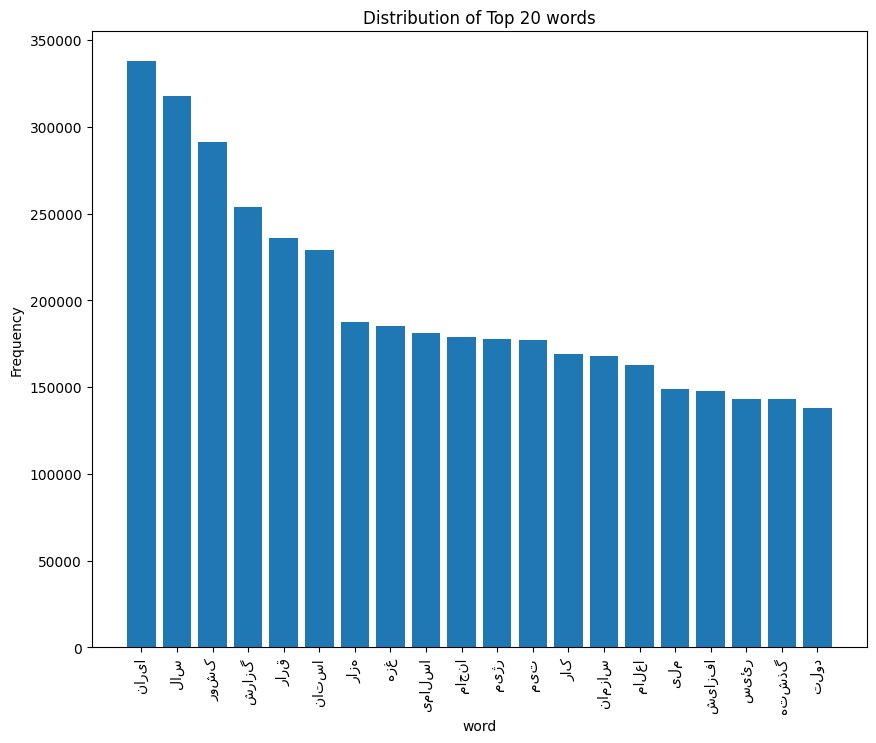

In [46]:
# Count the frequency of each keyword and take the top 20
word_freq = processed_news_rdd.flatMap(lambda line: line.split(" "))\
                                  .map(lambda word: (word, 1))\
                                  .reduceByKey(lambda x, y: x + y)\
                                  .sortBy(lambda x: -x[1]).take(20)

# Plot
plt.figure(figsize=(10, 8))
plt.bar([x[0][::-1] for x in word_freq], [x[1] for x in word_freq])
plt.xticks(rotation=90)
plt.xlabel("word")
plt.ylabel("Frequency")
plt.title("Distribution of Top 20 words")
plt.show()


- find the `word clouds` of the news.

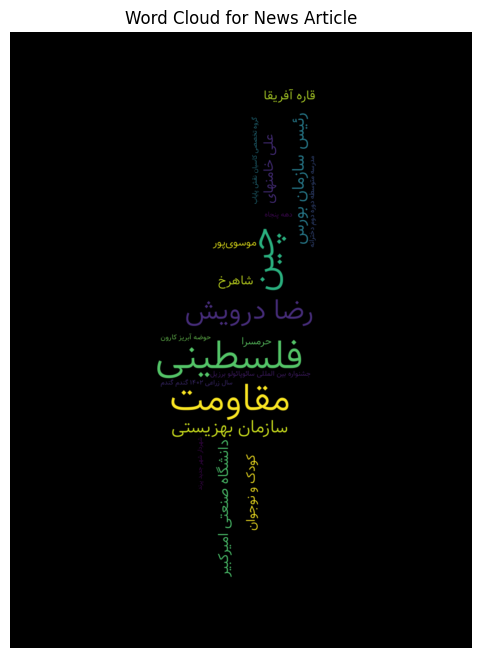

In [124]:
keyword_freq_rdd = news_rdd.filter(lambda x: "keywords" in json.loads(x))\
                             .map(lambda x: json.loads(x)["keywords"])\
                             .flatMap(lambda x: [(keyword, 1) for keyword in x])\
                             .reduceByKey(lambda x, y: x + y)

keyword_score_rdd = keyword_freq_rdd.map(lambda x: (x[0], 2 ** (math.log10(x[1]))))
keyword_score_sorted_rdd = keyword_score_rdd.sortBy(lambda x: -x[1])

# Normalize the scores
max_score = keyword_score_rdd.map(lambda x: x[1]).max()
keyword_norm_rdd = keyword_score_rdd.map(lambda x: (x[0], x[1] / max_score))

# get the 20 most frequent keyword as a list and convert it to dictionary
keywords_dict = dict(keyword_norm_rdd.take(20))

# Generate the word cloud
mask = cv2.imread('mask3.png', cv2.IMREAD_GRAYSCALE)
wordcloud = WordCloudFa(persian_normalize=True,
                        no_reshape=True, mask=mask,
                        background_color="black")\
                        .generate_from_frequencies(keywords_dict)
# Plot the word cloud
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for News Article")
plt.show()

- plot a timeline which shows total count of news per each day.

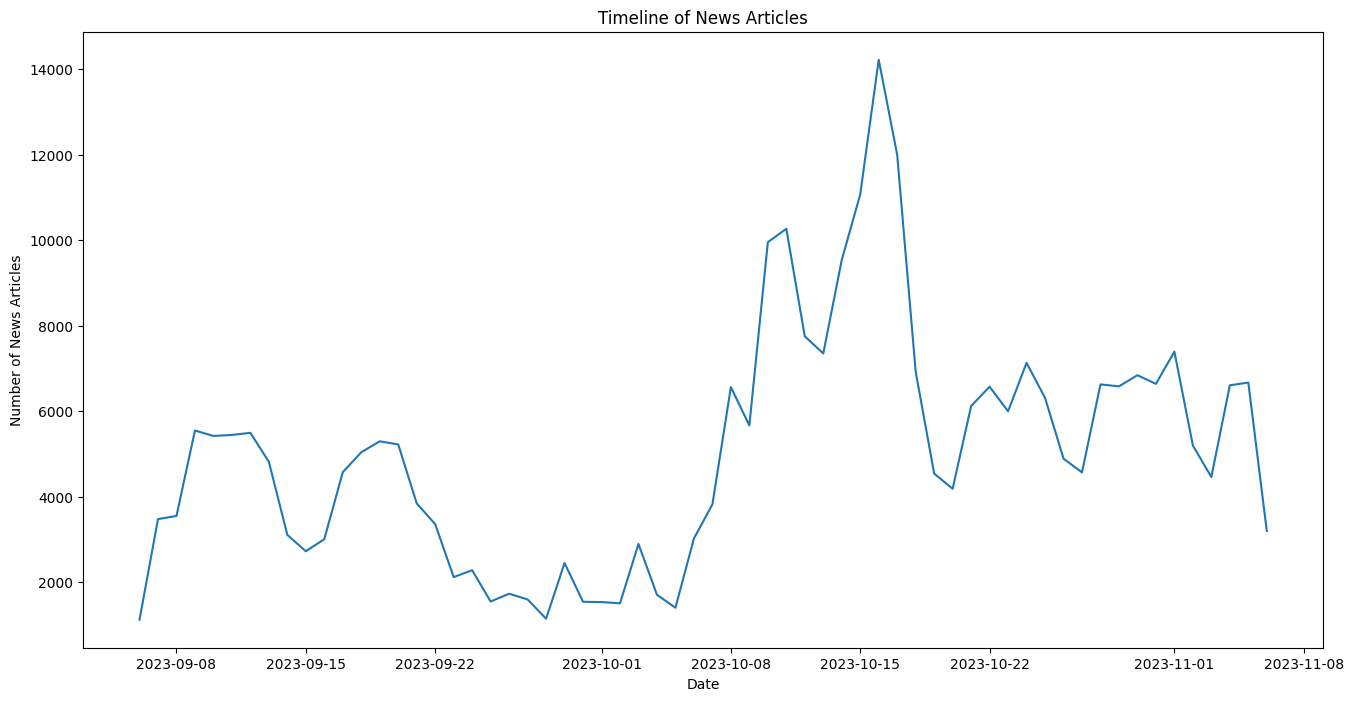

In [122]:
# Parse the JSON string and extract the date_published of each news article
date_rdd = news_rdd.map(lambda x: datetime.fromtimestamp(json.loads(x)["date_published"]))

# Count the number of news articles per day
count_rdd = date_rdd.map(lambda x: (x.date(), 1)).reduceByKey(lambda x, y: x + y)

# Convert the RDD to a list of tuples and sort by date
count_list = sorted(count_rdd.collect())

# Extract the dates and counts from the list
dates = [x[0] for x in count_list]
counts = [x[1] for x in count_list]

# Plot the timeline
plt.figure(figsize=(16, 8))
plt.plot(dates, counts)
plt.xlabel("Date")
plt.ylabel("Number of News Articles")
plt.title("Timeline of News Articles")
plt.show()

- plot a timeline which shows total count of news per each day that have at least one of the word clouds.


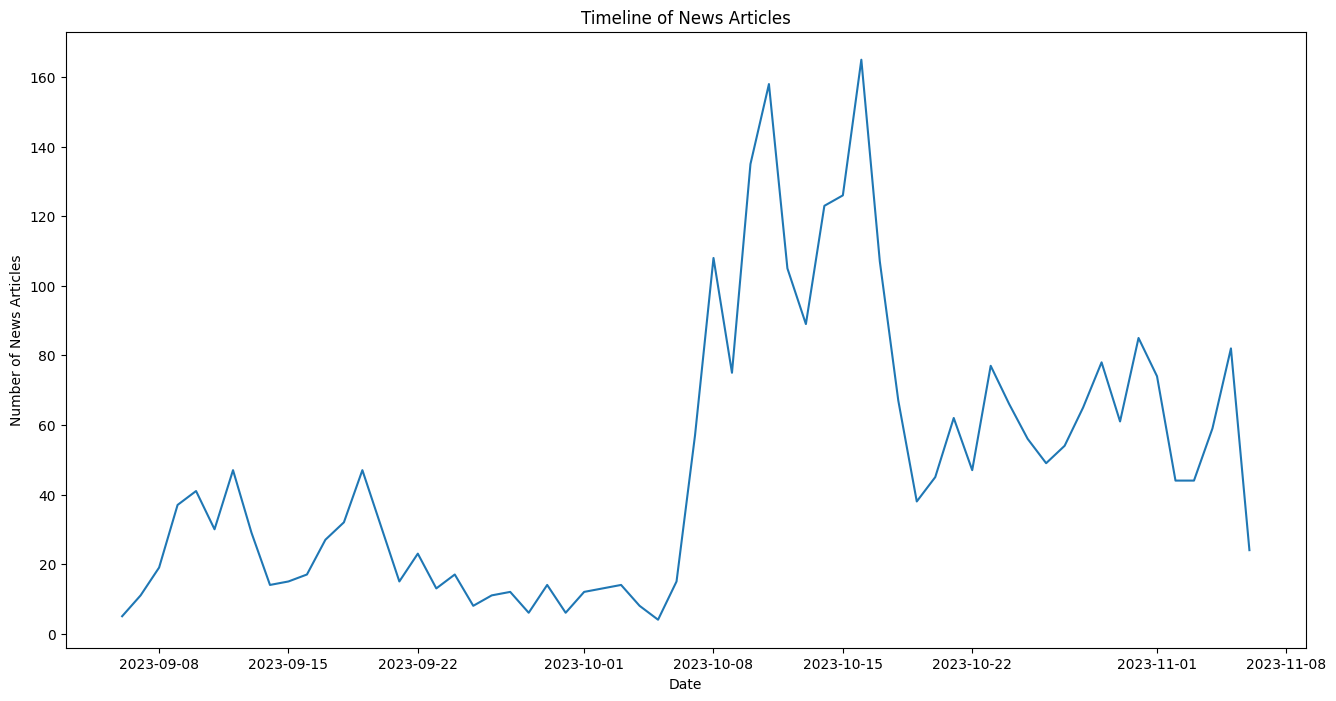

In [125]:
# Parse the JSON string and extract the date_published of each news article
date_keywords_rdd = news_rdd.filter(lambda x: "keywords" in json.loads(x))\
                            .map(lambda x: (datetime.fromtimestamp(json.loads(x)["date_published"]), json.loads(x)["keywords"]))

# Filter the RDD to include only news articles that have at least one keyword
filtered_rdd = date_keywords_rdd.filter(lambda x: len(x[1])>0) \
                                 .filter(lambda x: max([(1 if keyword in keywords_dict.keys() else 0) for keyword in x[1]]) > 0)

# Count the number of news articles per day
count_rdd = filtered_rdd.map(lambda x: (x[0].date(), 1)).reduceByKey(lambda x, y: x + y)

# Convert the RDD to a list of tuples and sort by date
count_list = sorted(count_rdd.collect())

# Extract the dates and counts from the list
dates = [x[0] for x in count_list]
counts = [x[1] for x in count_list]

# Plot the timeline
plt.figure(figsize=(16, 8))
plt.plot(dates, counts)
plt.xlabel("Date")
plt.ylabel("Number of News Articles")
plt.title("Timeline of News Articles")
plt.show()

- what is your inference about the below timeline.

# Section 4: Son, A-prior algorithm
- In this section we want to find 3-sets words collections that appear together the most.
    - What is your idea to solve the problem?
    - Implement an algorithm for doing so.
    - What is the most pertinant 3-sets words?
- Now we want to test the results and know that how valid is the model.
    - How we can test the model?
    - Explain and implement a scenario to test the model with using `tf-idf`.

In [6]:
news_count = processed_news_rdd.count()
print(f"The number of news: {news_count}")
s1 = int(news_count*0.05) # repeated at least in 5% of news
s2 = int(news_count*0.03) # repeated at least in 3% of news
s3 = int(news_count*0.005) # repeated at least in 0.5% of news
ct1 = 0.5 # confidence threshold for (i) --> (i,j) 
ct2 = 0.4 # confidence threshold for (i, j) --> (i, j, k) 


The number of news: 313273


In [7]:
# # TODO: find the answers of the above questions.
# convert each body to a set of words
processed_news_set_rdd = processed_news_rdd.map(lambda line: set(line.split(" ")))

# calculate the frequency of each words
word_freq_rdd = processed_news_set_rdd.flatMap(lambda x: ((word, 1) for word in x))\
                                  .reduceByKey(lambda x, y: x + y)

# choose the frequent words (with their frequency)
word_freq_filtered_rdd = word_freq_rdd.filter(lambda x: (x[1] > s1))

# save frequent words as two list: words(freq_word) and their corresponding frequency(freq_w)
word_freq = word_freq_filtered_rdd.collect()
freq_word = [w for w, _ in word_freq]
freq_w = [f for _, f in word_freq]

words_cnt = len(word_freq)
print(f"The number of words that are repeated in more than {s1} news: {words_cnt}")


# for each body, create a vector that show that it have or have not each words (the vectors contain 0 and 1)
body_word_vector_rdd = processed_news_set_rdd.map(lambda x: [1 if w in x else 0 for w in freq_word])


# now for each body, creates all pair of words that both words are frequent and satisfy necessary condition for confidence threshold
pair_rdd = body_word_vector_rdd.flatMap(lambda x: (((i,j), 1) \
                                                         if (x[i] and x[j] and i!=j and freq_w[i]*ct1<freq_w[j]and freq_w[j]*ct1<freq_w[i])\
                                                         else ((0),0)\
                                                         for i in range(words_cnt) \
                                                         for j in range(i+1, words_cnt)))

# remove redundant tuples and reduceByky(.) to calculate frequency of each pairs
pair_freq_rdd = pair_rdd.filter(lambda x: x[1] > 0).reduceByKey(lambda x, y: x + y)

# now we have pairs with frequent words
# choose frequent pairs that satisfy condition for confidence threshold
freq_pair_rdd = pair_freq_rdd.filter(lambda x: (x[1] > max(s2, freq_w[x[0][0]]*ct1, freq_w[x[0][1]]*ct1)))#.map(lambda x:x[0])

# save frequent pairs as two list: pairs and their corresponding frequency(freq_p)
freq_pair = freq_pair_rdd.collect()
pairs = [p for p, _ in freq_pair]
freq_p = [f for _, f in freq_pair]

pairs_cnt = len(pairs)
print(f"The number of pairs that are repeated in more than {s2} news and satisfy confidence threashold: {pairs_cnt}")

# now for each body, creates all triple of words that consist of frequent words
triple_rdd = body_word_vector_rdd.flatMap(lambda x: (((i,j,k), 1) \
                                                               if (x[i] and x[j] and x[k])\
                                                               else ((0),0) \
                                                               for i,j in pairs \
                                                               for k in range(j+1, words_cnt)))

# remove redundant tuples and reduceByky(.) to calculate frequency of each tuples
triple_freq_rdd = triple_rdd.filter(lambda x: x[1] > 0)\
                            .reduceByKey(lambda x, y: x + y)

# now we have tuples with frequent words
# choose frequent tuples that satisfy necessary condition for confidence threshold
freq_triple_rdd = triple_freq_rdd.filter(lambda x: x[1] > max(s3, freq_p[pairs.index((x[0][0],x[0][1]))]*ct2))

# save frequent tuples in a list
triple_freq = freq_triple_rdd.collect()

print(f"The number of triples that are repeated in more than {s3} news: {len(triple_freq)}")

The number of words that are repeated in more than 15663 news: 381


The number of pairs that are repeated in more than 9398 news and satisfy confidence threashold: 10


The number of triples that are repeated in more than 1566 news: 34


In [46]:
triple_freq.sort(key=lambda x: -x[1])
for (i,j,k),count in triple_freq:
    print(freq_word[i], freq_word[j], freq_word[k], count)


صهیونیستی غزه رژیم 25676
صهیونیستی رژیم فلسطین 23218
غزه رژیم فلسطین 20238
صهیونیستی غزه فلسطین 18889
اسرائیل غزه رژیم 14250
اسرائیل غزه فلسطین 13944
صهیونیستی غزه اعلام 13914
غزه رژیم آمریکا 11737
صهیونیستی غزه حملات 11618
غزه رژیم منطقه 11608
اسرائیل غزه اعلام 11543
صهیونیستی غزه حمایت 11225
لیگ فوتبال تیم 11004
صهیونیستی غزه عملیات 10951
غزه فلسطین منطقه 10909
صهیونیستی غزه آمریکا 10900
صهیونیستی غزه منطقه 10851
رژیم فلسطین منطقه 10723
رژیم فلسطین آمریکا 10502
غزه فلسطین آمریکا 10406
صهیونیستی فلسطین منطقه 10023
اسرائیل غزه حملات 9834
صهیونیستی فلسطین آمریکا 9771
اسرائیل غزه آمریکا 9692
اسرائیل غزه منطقه 9418
اسرائیل غزه حمایت 9250
لیگ فوتبال بازی 9157
اسرائیل غزه عملیات 9003
لیگ فوتبال هفته 6694
لیگ فوتبال برتر 6385
لیگ فوتبال حضور 5692
لیگ فوتبال ایران 5578
لیگ فوتبال باشگاه 5496
لیگ فوتبال بازیکن 5247


In [117]:
idf_rdd = word_freq_filtered_rdd.map(lambda x: math.log10(1+news_count/x[1]))
idf = idf_rdd.collect()

clean_news_rdd2 = news_rdd.filter(lambda x: "keywords" in json.loads(x))\
                          .map(lambda x:  (json.loads(x)["uid"],  " ".join(json.loads(x)["keywords"]), re.sub('[^\w\s]+', '', json.loads(x)["body"])))

processed_news_rdd2 = clean_news_rdd2.map(lambda x:(x[0], re.sub('[^\w\s]+', '', x[1]), " ".join([word for word in x[2].split() if word not in stop_words])))

tf_rdd = processed_news_rdd2.map(lambda x: (x[0], x[1], [len(re.findall(w, x[2])) for w in freq_word]))\
                           .map(lambda x: (x[0], x[1], [tf/(sum(x[2])+0.001)*idf[i] for i,tf in enumerate(x[2])]))


In [120]:
def find_news(word_index, n):
    # n: number of news
    tf_i = tf_rdd.map(lambda x: (x[0], x[1], x[2][word_index]))\
                 .filter(lambda x: x[2]>0.1).collect()
    tf_i.sort(key=lambda x: -x[2])
    return tf_i[:min(n,len(tf_i))]
          

In [121]:
triple = triple_freq[np.random.randint(len(triple_freq))]
print('the choosen triple: ',end=" ")
(i,j,k),count = triple
print(freq_word[i], freq_word[j], freq_word[k], count, end='\n\n')

keywords_in_news = []
for w in triple[0]:
    news = find_news(w, 3)
    print('news related to word \" ' + freq_word[w] +'\":\n')
    for new in news:
        print(f'\t word\'s tf-idf: {new[2]}')
        print(f'\t news UID: {new[0]}')
        print(f'\t news Key words: {new[1]}', end='\n\n')
    print('------------------------------------------\n')
    

the choosen triple:  لیگ فوتبال بازیکن 5247



news related to word " لیگ":

	 word's tf-idf: 0.6580805799761875
	 news UID: 559c9325975fcd9508411f6ed
	 news Key words: استقلال پرسپولیس پیوس پرسپولیس برتر

	 word's tf-idf: 0.49357414385181764
	 news UID: 2c263e066d736c3a273cf7f2a
	 news Key words: لیگ دسته اول لیگ دسته یک استقلال آب لیگ آزادگان

	 word's tf-idf: 0.45560982234948566
	 news UID: 85c0ba1c960e4ae3027fbfc88
	 news Key words: تیم داوری ایران لیگ قهرمانان آسیا لیگ قهرمانان نمایندگان ایران

------------------------------------------



news related to word " فوتبال":

	 word's tf-idf: 0.43308330259450356
	 news UID: dd3a71a11ff5eeae751bb826b
	 news Key words: نایب رئیس اول فدراسیون فوتبال الاتحاد

	 word's tf-idf: 0.4094548507976468
	 news UID: 5ad8dcbe931fe491e0c2d1ce5
	 news Key words: توپ طلا لیونل مسی آلمان اروپا

	 word's tf-idf: 0.4021509904314792
	 news UID: 5eb763f5bc628d894c0b6f719
	 news Key words: تیمهای یاران رادبوی جوانان شهر ری نیروی انتظامی مسابقات فوتبال پایه تهران رادبوی

------------------------------------------



news related to word " بازیکن":

	 word's tf-idf: 0.3402921063011857
	 news UID: ed8128da6c24fe42b3c2d6cd6
	 news Key words: اعتصاب بازیکنان استقلال آبی پوشان اعتصاب بازیکنان بازیکنان استقلال

	 word's tf-idf: 0.30788487747387405
	 news UID: f17145c1c08c2c08ad6896bb8
	 news Key words: سرمربی تیم بسکتبال مهرام لیگ برتر بسکتبال کوهیان

	 word's tf-idf: 0.2770996883752222
	 news UID: cc32f008ca01f1d281f2db3e7
	 news Key words: بازیکنان سری آ ریتینگ بازیکنان رم EA Sports بازیکنان میلان

------------------------------------------



In [113]:
print('the choosen triple: ',end=" ")
(i,j,k),count = triple= triple_freq[np.random.randint(len(triple_freq))]
print(freq_word[i], freq_word[j], freq_word[k], count, end='\n\n')

# M = getM(triple[0], 1000)    
word_indexes = triple[0]
tf_idfs = tf_rdd.sample(False, 0.05, seed=42)\
                .map(lambda x: [(x[2][i]) for i in word_indexes])\
                .collect()
# tf_idfs.sort(key=lambda x:-sum(x[:]))

v1 = []
v2 = []
v3 = []
for t in tf_idfs[:]:
    v1.append(t[0])
    v2.append(t[1])
    v3.append(t[2])
M = [v1,v2,v3]
np.corrcoef(M)    

the choosen triple:  صهیونیستی غزه رژیم 25676



array([[1.        , 0.38028613, 0.8536828 ],
       [0.38028613, 1.        , 0.37969394],
       [0.8536828 , 0.37969394, 1.        ]])

In [114]:
print('the choosen triple: ',end=" ")
(i,j,k),count = triple2= ((100,120,130),0)
print(freq_word[i], freq_word[j], freq_word[k], count, end='\n\n')

# M = getM(triple[0], 1000)    
word_indexes = triple2[0]
tf_idfs2 = tf_rdd.sample(False, 0.05, seed=42)\
                .map(lambda x: [(x[2][i]) for i in word_indexes])\
                .collect()
tf_idfs2.sort(key=lambda x:-sum(x[:]))

v12 = []
v22 = []
v32 = []
for t in tf_idfs2[:100]:
    v12.append(t[0])
    v22.append(t[1])
    v32.append(t[2])
M2 = [v12,v22,v32]
np.corrcoef(M2)    

the choosen triple:  مسیر اقدام فضای 0



array([[ 1.        , -0.20704585, -0.61621424],
       [-0.20704585,  1.        , -0.23631447],
       [-0.61621424, -0.23631447,  1.        ]])